# More Advanced Techniques (and Architectures)
We have thus far studied a number of convolutional networks for performing classification, specifically using the Fashion MNIST dataset. However, as the classification problem becomes more complicated, it will require more complicated architectures and more involved methods for regularizing the data. For instance, object recognition requires more knowledge than simple handwriting digits (as in the case of recognizing shirts in Fashion MNIST). The complexities of the picture are more varied, color has an influence, and much more. Therefore, the simple convolutions that we used before might not be expressive enough without a number of additional layers. 

Let's try some of these techniques with Fashion MNIST data. Some of these concepts we have already talked about, such as different initializations and different regularizers. Namely, we will cover these concepts:

- Expansion
- Initialization
- Batch Normalization
- Ensembling
- Building Blocks from More Advanced Networks (bypass, branching, etc.)

After going through this tutorial, you will have an understanding of how to use some of the more advanced techniques--however we are limited here by the hardware and time in lecture. Many modern architectures can take days/weeks to train and are extremely deep (look at the 100+ layers of ResNet-112). However, some of the architectures from ~2013 and ~2014 are manageable to investigate and take only a few hours to train. We will cover a few concepts for getting models up and running, and maybe even use more some complicated architectures. Let's get started! 

This is also an excellent tutorial with even more information than I am showing for the fine tuning techniques:
- https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.0.2'

In [2]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    
        

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [6]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

NUM_CLASSES = 10
img_wh = 28

# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

Rows: 60000, columns: 784
Rows: 10000, columns: 784
New Shape: Rows: 60000, image size: (28,28,1)


(60000, 28, 28, 1)


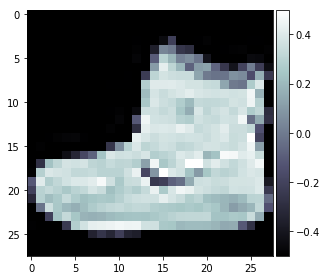

In [23]:
print(X_train.shape)
imshow(X_train[0].squeeze(),cmap='bone')

## Starting simple
Let's first start by using data expansion on the Fashion MNIST dataset.

In [63]:
classes = ['T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle boot ']

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

idx = 0

0


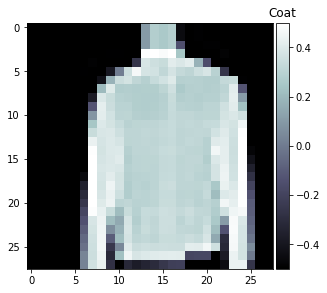

In [38]:
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    plt.title(classes[np.argmax(tmp[1])])
    break

In [44]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )


Epoch 1/5
468/468 [==============================] - 309s - loss: 0.8288 - acc: 0.7043 - val_loss: 0.4612 - val_acc: 0.8229
Epoch 2/5
468/468 [==============================] - 306s - loss: 0.5593 - acc: 0.7992 - val_loss: 0.3900 - val_acc: 0.8559
Epoch 3/5
468/468 [==============================] - 309s - loss: 0.4923 - acc: 0.8219 - val_loss: 0.3523 - val_acc: 0.8701
Epoch 4/5
468/468 [==============================] - 307s - loss: 0.4688 - acc: 0.8313 - val_loss: 0.3388 - val_acc: 0.8800
Epoch 5/5
468/468 [==============================] - 318s - loss: 0.4498 - acc: 0.8415 - val_loss: 0.3424 - val_acc: 0.8776
CPU times: user 1h 10min 48s, sys: 8min 56s, total: 1h 19min 45s
Wall time: 25min 52s


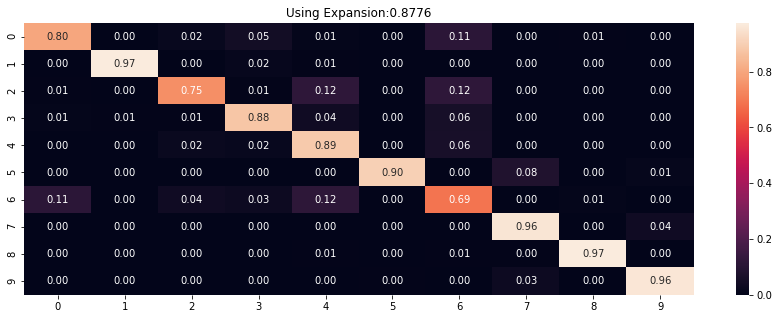

In [45]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

In [48]:
# what if we just want to use the validation data??
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/50
468/468 [==============================] - 510s - loss: 0.8738 - acc: 0.7235 - val_loss: 0.5087 - val_acc: 0.8556
Epoch 2/50
468/468 [==============================] - 498s - loss: 0.5728 - acc: 0.8339 - val_loss: 0.4603 - val_acc: 0.8750
Epoch 3/50
468/468 [==============================] - 524s - loss: 0.5078 - acc: 0.8605 - val_loss: 0.4348 - val_acc: 0.8843
Epoch 4/50
468/468 [==============================] - 534s - loss: 0.4727 - acc: 0.8716 - val_loss: 0.4252 - val_acc: 0.8823
Epoch 5/50
468/468 [==============================] - 540s - loss: 0.4508 - acc: 0.8794 - val_loss: 0.4048 - val_acc: 0.8909
Epoch 6/50
468/468 [==============================] - 542s - loss: 0.4328 - acc: 0.8871 - val_loss: 0.3875 - val_acc: 0.9004
Epoch 7/50
468/468 [==============================] - 543s - loss: 0.4252 - acc: 0.8897 - val_loss: 0.3759 - val_acc: 0.9039
Epoch 8/50
468/468 [==============================] - 484s - loss: 0.4118 - acc: 0.8933 - val_loss: 0.3791 - val_acc: 0.9012


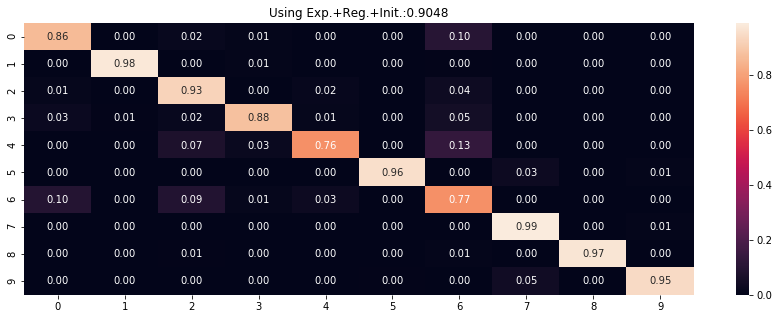

In [49]:
summarize_net(cnn, X_test, y_test, title_text='Using Exp.+Reg.+Init.:')

# Ensemble Nets
Now lets do the exact same thing, but with an average of three separate networks. 

To get this running, we are going to use the keras `Model API` which is different than the `Sequential API`. It requires that we explicitly define the inputs and outputs, and gives us a bit more control over the network topology.

- https://keras.io/models/model/

Reminder of Differences from Sequential and Functional APIs:
- You will need to specify the input and output nodes explicitly.
 - `input_layer = Input(shape=(**insert shape here**))`
- You no longer `add` to a `Sequential`, you feed layer by layer:
 - `model.add(Dense())` becomes `layer2 = Dense()(input_layer)`
 - subsequent layers use temporary variables like `layer1` and `input_layer` above
- Tell the Model what the input and output temporary variables are:
 - `model = Model(inputs=input_layer,outputs=layer1)`
 - then you can call `model.compile()`
- A great example that uses the Model API with MNIST:
 - https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [64]:
%%time

from keras.layers import average, concatenate
from keras.models import Input, Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_220 (Conv2D)              (None, 28, 28, 32)    320                                          
____________________________________________________________________________________________________
conv2d_221 (Conv2D)              (None, 28, 28, 32)    9248                                         
____________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D)  (None, 14, 14, 32)    0                                            
___________________________________________________________________________________________

In [65]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
468/468 [==============================] - 423s - loss: 0.8863 - acc: 0.6821 - val_loss: 0.5027 - val_acc: 0.8150
Epoch 2/50
468/468 [==============================] - 366s - loss: 0.5400 - acc: 0.8014 - val_loss: 0.4040 - val_acc: 0.8533
Epoch 3/50
468/468 [==============================] - 367s - loss: 0.4571 - acc: 0.8322 - val_loss: 0.3512 - val_acc: 0.8723
Epoch 4/50
468/468 [==============================] - 383s - loss: 0.4109 - acc: 0.8497 - val_loss: 0.3223 - val_acc: 0.8813
Epoch 5/50
468/468 [==============================] - 455s - loss: 0.3791 - acc: 0.8629 - val_loss: 0.3076 - val_acc: 0.8895
Epoch 6/50
468/468 [==============================] - 413s - loss: 0.3616 - acc: 0.8664 - val_loss: 0.2973 - val_acc: 0.8924
Epoch 7/50
468/468 [==============================] - 414s - loss: 0.3413 - acc: 0.8756 - val_loss: 0.2841 - val_acc: 0.8975
Epoch 8/50
468/468 [==============================] - 403s - loss: 0.3277 - acc: 0.8799 - val_loss: 0.2709 - val_acc: 0.9001


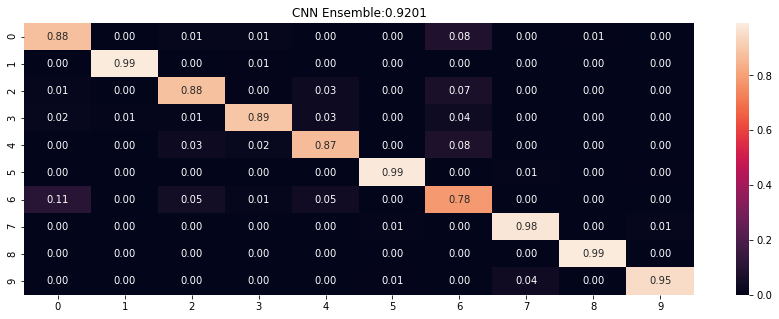

In [66]:
summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')

___
# Adding ResNet Style Blocks
Okay, so now lets try a trick from 2016---ancient in terms of deep learning years (that's a joke 🤷, ¯\\_(ツ)_/¯). 

The ResNet-Style Bypass is described in the following:
![resnet](https://cdn-images-1.medium.com/max/1600/0*0r0vS8myiqyOb79L.jpg)

In [72]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from keras.layers.normalization import BatchNormalization
from keras.layers import Add

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_259 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_260 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_261 (Conv2D)          (None, 7, 7, 64)          2112      
_________________________________________________________________
conv2d_262 (Conv2D)          (None, 7, 7, 64)          36928     
__________

In [73]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
468/468 [==============================] - 120s - loss: 0.9298 - acc: 0.6565 - val_loss: 0.5350 - val_acc: 0.8000
Epoch 2/50
468/468 [==============================] - 116s - loss: 0.6024 - acc: 0.7756 - val_loss: 0.4598 - val_acc: 0.8276
Epoch 3/50
468/468 [==============================] - 116s - loss: 0.5329 - acc: 0.8010 - val_loss: 0.4011 - val_acc: 0.8520
Epoch 4/50
468/468 [==============================] - 118s - loss: 0.4885 - acc: 0.8185 - val_loss: 0.3747 - val_acc: 0.8602
Epoch 5/50
468/468 [==============================] - 116s - loss: 0.4548 - acc: 0.8324 - val_loss: 0.3636 - val_acc: 0.8633
Epoch 6/50
468/468 [==============================] - 115s - loss: 0.4389 - acc: 0.8381 - val_loss: 0.3485 - val_acc: 0.8676
Epoch 7/50
468/468 [==============================] - 116s - loss: 0.4199 - acc: 0.8476 - val_loss: 0.3465 - val_acc: 0.8703
Epoch 8/50
468/468 [==============================] - 116s - loss: 0.4058 - acc: 0.8501 - val_loss: 0.3459 - val_acc: 0.8659


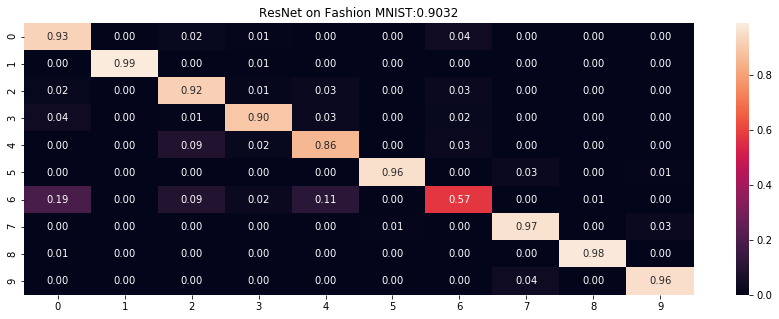

In [74]:
summarize_net(resnet, X_test, y_test, title_text='ResNet on Fashion MNIST:')

# Using Pre-trained Models

In [77]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')

CPU times: user 13.8 s, sys: 695 ms, total: 14.5 s
Wall time: 14.4 s


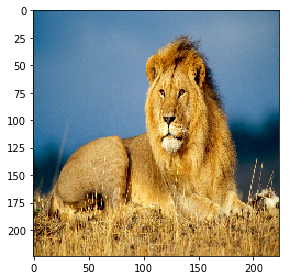

In [79]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.io import imshow

img_path = 'data/Simba.jpg'
img = image.load_img(img_path, target_size=(224, 224))
imshow(image.img_to_array(img)/255)
plt.grid(False)

In [80]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129165', 'lion', 0.99565792), ('n02130308', 'cheetah', 0.00087043433), ('n07802026', 'hay', 0.00061646383)]


Predicted: [('n04285008', 'sports_car', 0.8644473), ('n03100240', 'convertible', 0.058732931), ('n02974003', 'car_wheel', 0.03669025), ('n03459775', 'grille', 0.024440043), ('n04037443', 'racer', 0.004445564), ('n03770679', 'minivan', 0.0025865666), ('n04483307', 'trimaran', 0.0018270797), ('n02814533', 'beach_wagon', 0.0017102587), ('n04442312', 'toaster', 0.0014616875), ('n02965783', 'car_mirror', 0.00089074828)]


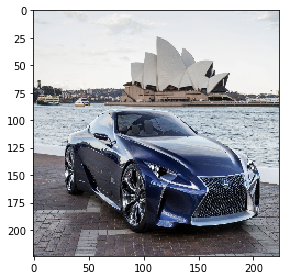

In [81]:
img_path = 'data/MyCar.jpg'
img = image.load_img(img_path, target_size=(224, 224))
imshow(image.img_to_array(img)/255)
plt.grid(False)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=10)[0])

_____
_____
**Self Test: Should we do this Live?**

- A. Yes.
- B. No.
- C. It Depends
- D. We're gonna do it anyway

If you have OpenCV installed, you can try this.

**Imposter Syndrome:**

<img src="http://img.memecdn.com/glad-to-know-that-i-amp-039-ve-changed-my-path-years-before_o_7095071.jpg" style="width:500px;">


In [ ]:
import cv2
import numpy as np
import time
import itertools
%matplotlib inline

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

if 'res_model' not in locals():
    res_model = ResNet50(weights='imagenet')

ESC_KEY = 27

# setup some windows for viewing
cv2.namedWindow("demowin1")
cv2.startWindowThread()

# open the video card for capture
vc = cv2.VideoCapture(0)

if vc.isOpened():  # try to get the first frame
    print ("vc opened, getting first frame")
    rval, frame = vc.read()
    # this will likely fail the first time
    # the webcam often needs some time to open fully
    key = 0
else:
    print ("vc not open, exiting")
    key = ESC_KEY

while key != ESC_KEY and vc.isOpened():  # the escape key and the capture device is open
    rval, frame = vc.read()
    key = cv2.waitKey(10)

    if rval and frame is not None:
        
        frame_to_show = cv2.pyrDown(frame)  # make smaller immediately
        # grab the ROI in top left (will show later on)
        frame_down = frame_to_show[0:224,0:224]
        
        # increase contrast
        img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
        frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

        # and then remove noise
        frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,7,3,11)
        
        img = frame_down.copy() # make a copy for numpy

        x = image.img_to_array(img[:,:,::-1]) # convert to numpy
        x = np.expand_dims(x, axis=0) # add batch dimension
        x = preprocess_input(x) # apply resnet presets

        preds = res_model.predict(x) # get the predictions
        
        # decode the results into a list of tuples (class, description, probability)
        txt = str(decode_predictions(preds, top=3)[0])

        cv2.putText(frame_to_show, txt, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255])
        cv2.rectangle(frame_to_show, (0,0), (244,244), (255,255,255), 1)
        cv2.imshow("demowin1", frame_to_show)
    
print('releasing...')
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('Done')

Using TensorFlow backend.


vc opened, getting first frame


# Transfer Learning With ResNet

In [3]:
from keras.datasets import cifar10
from scipy.misc import imresize

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [4]:
%%time
x_train_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

(50000, 224, 224, 3)
(10000, 224, 224, 3)
CPU times: user 25.5 s, sys: 31.4 s, total: 56.9 s
Wall time: 1min 58s


In [5]:
# connect new layers to the output
x = res_model.output

# let's add a fully-connected layer
x = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=res_model.input, outputs=predictions)

# freeze ResNet during training
for layer in res_model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_up,y_train_ohe,epochs=1,batch_size=64,verbose=1)

Epoch 1/1
50000/50000 [==============================] - 31532s - loss: 1.4507 - acc: 0.5314     

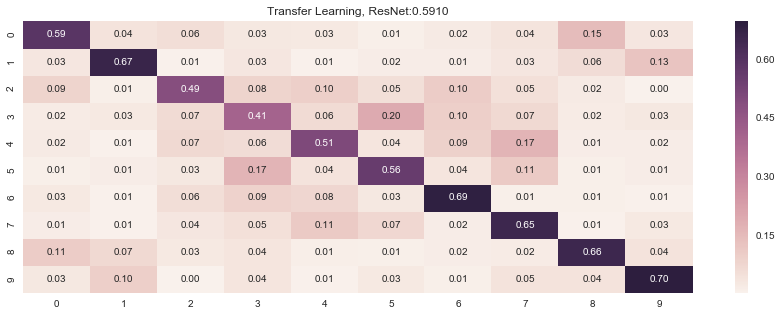

In [8]:
summarize_net(model, x_test_up, y_test, title_text='Transfer Learning, ResNet:')